## Imports

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
from sklearn import tree
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np

## Base de dados

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
caminho_base_treino = '/content/drive/MyDrive/desafio-lighthouse/desafio_manutencao_preditiva_treino.csv'  # se for rodar, modificar esse caminho
caminho_base_teste = '/content/drive/MyDrive/desafio-lighthouse/desafio_manutencao_preditiva_teste.csv'    # se for rodar, modificar esse caminho

dados_treino = pd.read_csv(caminho_base_treino)
dados_teste = pd.read_csv(caminho_base_teste)
dataset = dados_treino.copy()
dataset_teste = dados_teste.copy()
dataset

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,M14860,M,298.1,308.6,1551,42.8,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,No Failure
2,5,L47184,L,298.2,308.7,1408,40.0,9,No Failure
3,6,M14865,M,298.1,308.6,1425,41.9,11,No Failure
4,7,L47186,L,298.1,308.6,1558,42.4,14,No Failure
...,...,...,...,...,...,...,...,...,...
6662,9995,L57174,L,298.8,308.3,1634,27.9,12,No Failure
6663,9996,M24855,M,298.8,308.4,1604,29.5,14,No Failure
6664,9997,H39410,H,298.9,308.4,1632,31.8,17,No Failure
6665,9999,H39412,H,299.0,308.7,1408,48.5,25,No Failure


## Análise Exploratória dos Dados

### Função describe()

Através da função describe() é possível visualizar de maneira tabular algumas estatísticas descritivas dos dados (variáveis numéricas). Podemos observar, por exemplo, os valores médios destas variáveis, o desvio padrão (std), e a quantidade de registros (count).

In [4]:
dataset.describe()

,udi,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
count,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000
mean,4994.589921,299.992515,309.992620,1537.419529,40.058512,108.098095
std,2896.125718,1.994710,1.488101,177.182908,9.950804,63.359915
min,1.000000,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,2496.500000,298.300000,308.800000,1422.500000,33.200000,54.000000
50%,4983.000000,300.000000,310.000000,1503.000000,40.200000,108.000000
75%,7510.500000,301.500000,311.100000,1612.000000,46.800000,162.000000
max,10000.000000,304.500000,313.800000,2886.000000,76.600000,251.000000


### Gráfico do valor médio das variáveis numéricas

<ipython-input-5-3cf1dc4725e2>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  medias = dataset.mean()[2:9]


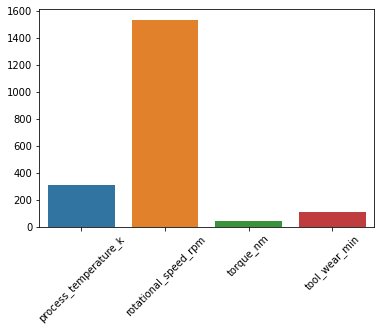

In [5]:
medias = dataset.mean()[2:9]
g=sns.barplot(x=medias.index, y=medias.values)
g.set_xticklabels(labels=medias.index, rotation=45);

### Gráfico da mediana das variáveis numéricas

<ipython-input-6-2c0dcc50c024>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  medianas = dataset.median()[2:9]


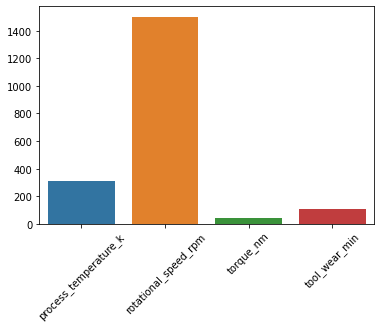

In [6]:
medianas = dataset.median()[2:9]
g=sns.barplot(x=medianas.index, y=medianas.values)
g.set_xticklabels(labels=medianas.index, rotation=45);

OBS: Através da mediana é possível observar que os valores das colunas são diferentes entre elas, com um destaque para a variável "rotacional_speed_rpm" que possui valores bem mais elevados que as outras variáveis. Uma padronização ou normalização dos dados pode ser interessante.

### Verificando se os dados estão balanceados

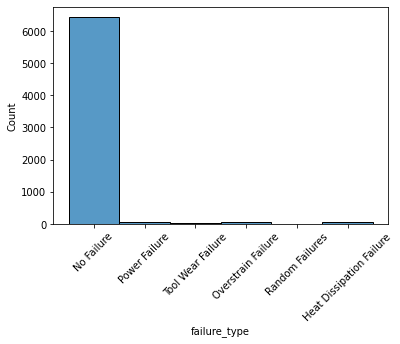

In [7]:
g = sns.histplot(data=dataset, x="failure_type")
g.set_xticklabels(labels=dataset.failure_type.unique(), rotation=45);

Ao plotar o histograma da distribuição do target "Failure_type", é notório que esta distribuição está desbalanceada, pois o tipo "No failure" é predominante no conjunto de dados. Informação que deve ser levada em consideração, pois pode influenciar o treinamento do modelo e até ocasionar o "Paradoxo da Acurácia". 

OBS: Algumas formas de resolver esta situação:

Adquirir mais dados das outras classes

Diminuir a quantidade de registros dos dados da classe "No Failure"

Uitlizar modelos que penalizem mais os erros quando classificarem essas categorias que pertencem a minoria. 

### Verificando outliers nos dados

Através do gráfico boxplot, é possível verificar as estatísticas: valor mínimo, o primeiro quartil (Q1), a mediana, o terceiro quartil (Q3) e o valor máximo. Bem como, é possível verificar a existência de outliers, os quais são valores discrepantes e que precisam ser observados, pois podem influenciar o comportamento de um modelo de machine learning. 
Nos boxplots abaixo, pode-se observar estas estatísticas para cada variável numérica de acordo com o tipo de defeito. Nota-se que as variáveis "rotational_speed_rpm", "torque_nm" e "tool_wear_min" possuem outliers em algumas das classes de defeito.

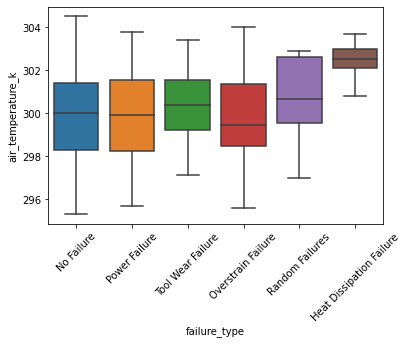

In [8]:
g = sns.boxplot(x=dataset["failure_type"], y=dataset["air_temperature_k"])
g.set_xticklabels(labels=dataset.failure_type.unique(), rotation=45);

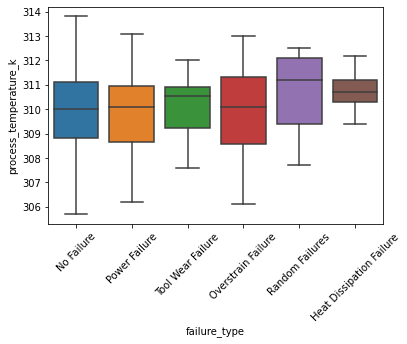

In [9]:
g = sns.boxplot(x=dataset["failure_type"], y=dataset["process_temperature_k"])
g.set_xticklabels(labels=dataset.failure_type.unique(), rotation=45);

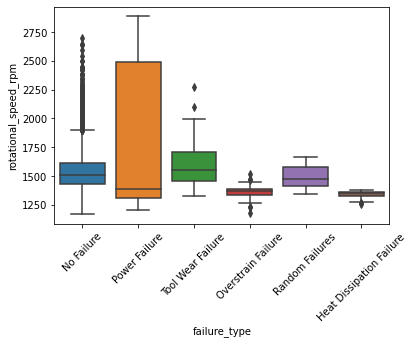

In [10]:
g = sns.boxplot(x=dataset["failure_type"], y=dataset["rotational_speed_rpm"])
g.set_xticklabels(labels=dataset.failure_type.unique(), rotation=45);

OBS: Essa variável (rotational_speed_rpm) mostra uma grande diferença nos valores quando o target é definido como Power Failure, o que faz pensar que um alto valor dessa variável pode significar que deve ser classificado como Power Failure.  

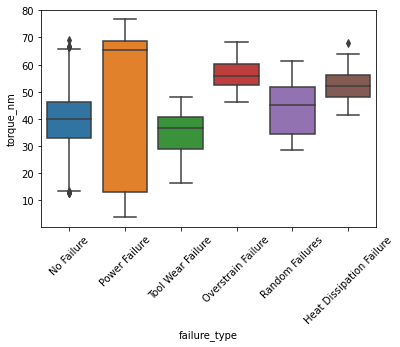

In [11]:
g = sns.boxplot(x=dataset["failure_type"], y=dataset["torque_nm"])
g.set_xticklabels(labels=dataset.failure_type.unique(), rotation=45);

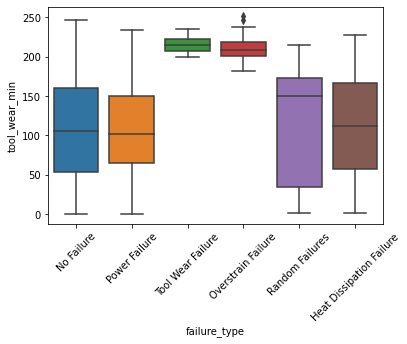

In [12]:
g = sns.boxplot(x=dataset["failure_type"], y=dataset["tool_wear_min"])
g.set_xticklabels(labels=dataset.failure_type.unique(), rotation=45);

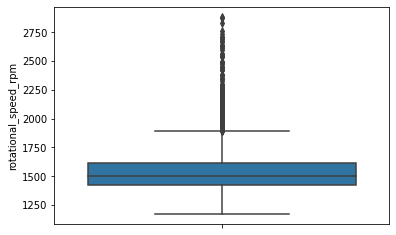

In [13]:
sns.boxplot(y=dataset["rotational_speed_rpm"])
plt.show()

OBS: Excluir os outliers de maneira geral (sem ser de acordo com as divisões de target), por exemplo excluir registros em que essa variável esteja acima de 2000, apagaria dados que poderiam diferenciar um target Power Failure dos demais targets.

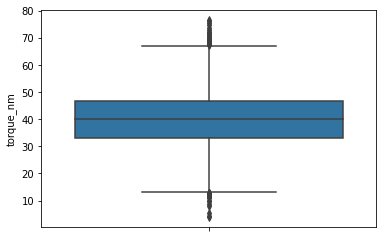

In [14]:
sns.boxplot(y=dataset["torque_nm"])
plt.show()

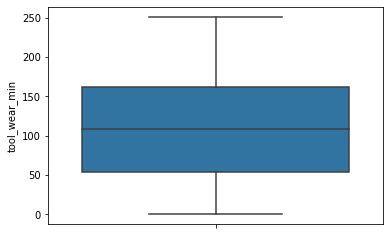

In [15]:
sns.boxplot(y=dataset["tool_wear_min"])

OBS: Ao analisar sem separar por "Failure_type", podemos notar que a variável "tool_wear_min" não apresenta os outliers como anteriormente

### Calculando a média aparada

Como foi observado outliers nos dados, a média aritmética pode ser afetada por estes. Utilizando a média aparada pode evitar que a média seja afetada por estes, dado que uma porcentagem dos valores mínimos e máximos podem ser excluídos. 

In [16]:
def media_aparada(df,porcentagem):

  for c in range(len(df.columns)):
    print('Média aparada variável', df.columns[c],':', stats.trim_mean(df[df.columns[c]] , porcentagem))

In [17]:
media_aparada(dataset.iloc[:,3:8],0.15) # Média aparada 15%

Média aparada variável air_temperature_k : 299.9372616241697
Média aparada variável process_temperature_k : 309.97739447182346
Média aparada variável rotational_speed_rpm : 1512.1240625669595
Média aparada variável torque_nm : 40.07846582386973
Média aparada variável tool_wear_min : 107.93829012213413


Comparando com os valores da média aritmética que a função describe forneceu

air_temperature_k : 299.992515	

process_temperature_k : 309.992620

rotational_speed_rpm : 1537.419529	

torque_nm : 40.058512	

tool_wear_min : 108.098095

Podemos observar que houve uma diferença mais significante na variável "rotational_speed_rpm", o que faz sentido se observarmos no boxplot que essa é a variável que mais possui outliers.

### Verificando a correlação entre as variáveis

Utilizando a função corr() e o gráfico do mapa de calor, pode-se observar a correlação entre as variáveis, ou seja podemos medir o quanto duas variáveis se relacionam. No mapa de calor abaixo, é notória uma correlação positiva entre as variáveis "air_temperature_k" e "process_temperature_k" e uma correlação negativa entre as variáveis "rotational_speed_rpm" e "torque_nm". Foi verificada essa correlação, porém ela seria importante se o modelo que fosse ser utilizado fosse de regressão, pois observaria a correlação entre cada variável preditora e a variável em que deseja-se prever. 

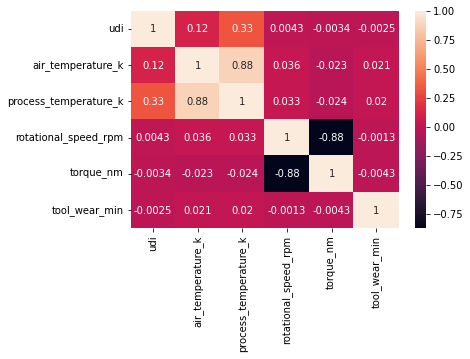

In [18]:
correlacao = dataset.corr()
sns.heatmap(correlacao, annot=True)

### Gráfico de Dispersão

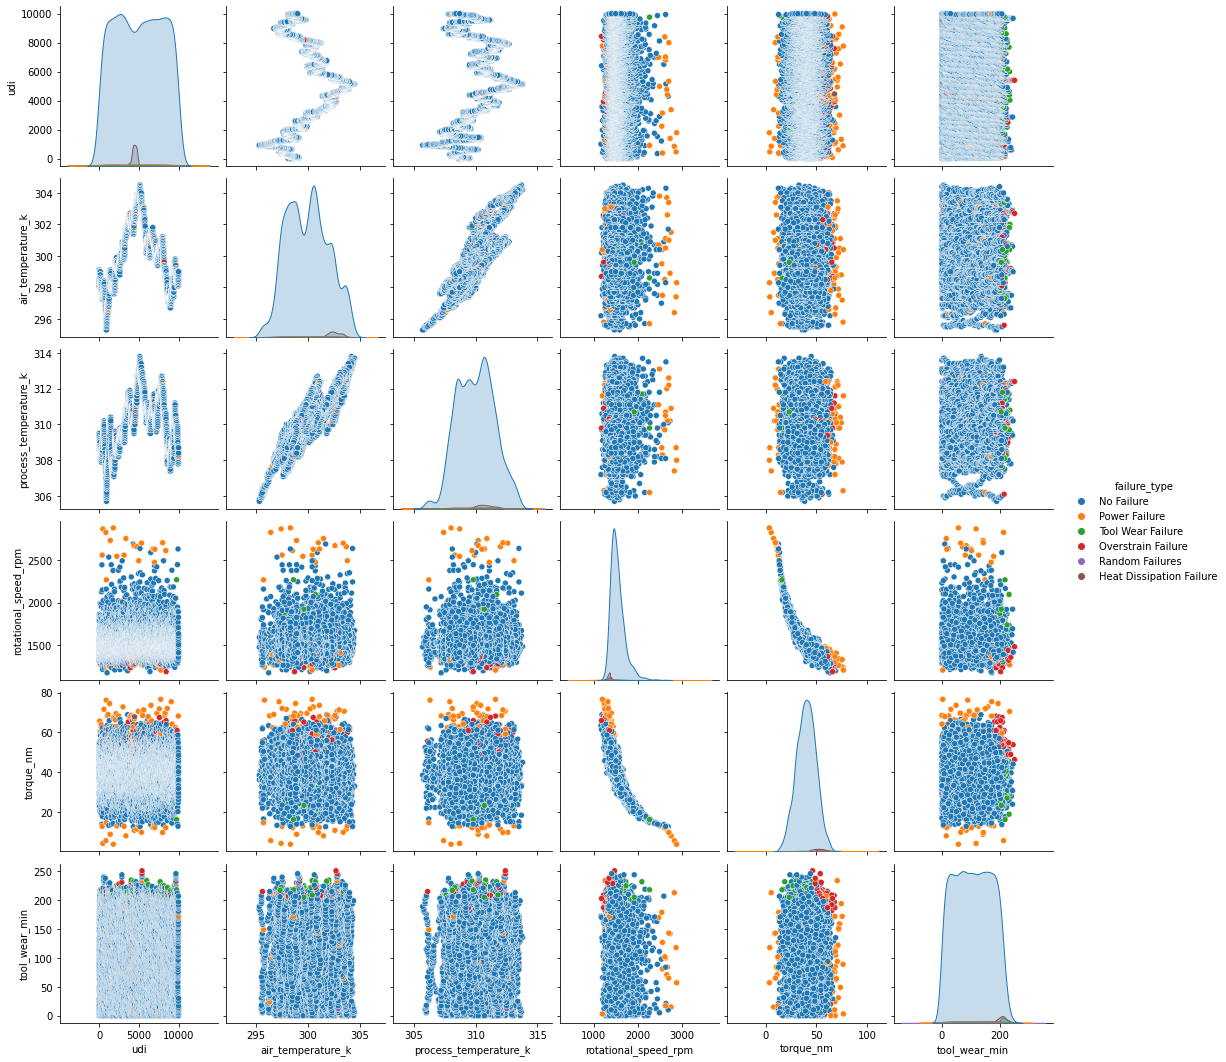

In [19]:
sns.pairplot(dataset, hue='failure_type')

## Pré-Processamento dos dados

In [20]:
# verificando os tipos dos dados e se existe alguma coluna com valores nulos
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6667 entries, 0 to 6666
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   udi                    6667 non-null   int64  
 1   product_id             6667 non-null   object 
 2   type                   6667 non-null   object 
 3   air_temperature_k      6667 non-null   float64
 4   process_temperature_k  6667 non-null   float64
 5   rotational_speed_rpm   6667 non-null   int64  
 6   torque_nm              6667 non-null   float64
 7   tool_wear_min          6667 non-null   int64  
 8   failure_type           6667 non-null   object 
dtypes: float64(3), int64(3), object(3)
memory usage: 468.9+ KB


In [21]:
dataset['failure_type'].unique() # verificando quais os valores de target

array(['No Failure', 'Power Failure', 'Tool Wear Failure',
       'Overstrain Failure', 'Random Failures',
       'Heat Dissipation Failure'], dtype=object)

In [22]:
dataset['type'].unique() # verificando quais os valores na coluna type, para escolher a melhor opção de transformar em valor numérico

array(['M', 'L', 'H'], dtype=object)

In [23]:
# transformando a coluna type de categórica para numérica conjunto de treino
dataset['type'] = dataset['type'].replace(['L','M','H'], [1,2,3]) 

# transformando a coluna type de categórica para numérica conjunto de teste
dataset_teste['type'] = dataset_teste['type'].replace(['L','M','H'], [1,2,3]) 


In [24]:
# verificando se a alteração foi realizada 
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6667 entries, 0 to 6666
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   udi                    6667 non-null   int64  
 1   product_id             6667 non-null   object 
 2   type                   6667 non-null   int64  
 3   air_temperature_k      6667 non-null   float64
 4   process_temperature_k  6667 non-null   float64
 5   rotational_speed_rpm   6667 non-null   int64  
 6   torque_nm              6667 non-null   float64
 7   tool_wear_min          6667 non-null   int64  
 8   failure_type           6667 non-null   object 
dtypes: float64(3), int64(4), object(2)
memory usage: 468.9+ KB


In [25]:
# verificando se a alteração foi realizada 
dataset_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   udi                    3333 non-null   int64  
 1   product_id             3333 non-null   object 
 2   type                   3333 non-null   int64  
 3   air_temperature_k      3333 non-null   float64
 4   process_temperature_k  3333 non-null   float64
 5   rotational_speed_rpm   3333 non-null   int64  
 6   torque_nm              3333 non-null   float64
 7   tool_wear_min          3333 non-null   int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 208.4+ KB


### Excluindo outliers

Ao analisar os outliers no bloxplot, os presentes na variável "rotational_speed_rpm" pareceram ser mais relevantes. Sendo assim eles foram escolhidos para serem excluídos.

In [26]:
# Excluindo registros que possuem outliers na coluna "rotational_speed_rpm" e são classificados como "No Failure"

dataset = dataset.drop(dataset[(dataset['rotational_speed_rpm'] > 2000) & (dataset['failure_type'] == 'No Failure')].index)

### Divisão da base de treino (para teste prévio)

In [27]:
# Dividindo a base de dados de treino em treino e teste para conseguir avaliar o modelo (As variáveis udi e product_id não serão usadas)
x = dataset.drop(columns=['udi','product_id','failure_type'])
y = dataset['failure_type'].values
X_treino, X_teste, Y_treino, Y_teste = train_test_split(x, y, test_size=0.25,stratify=y) # separando 25% da base para avaliação do modelo

### Normalizando os dados

In [28]:
# Função que deixa os dados entre 0-1
def normalizacao(df):
    return (df - df.min()) / ( df.max() - df.min())


In [29]:
X_treino = normalizacao(X_treino)

In [30]:
X_teste = normalizacao(X_teste)
X_teste

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
5336,1.0,0.613636,0.792208,0.129697,0.522535,0.844622
5617,0.0,0.420455,0.610390,0.232727,0.461972,0.685259
886,0.5,0.375000,0.545455,0.036364,0.970423,0.772908
140,0.0,0.318182,0.337662,0.237576,0.501408,0.418327
470,0.0,0.238636,0.415584,0.127879,0.625352,0.247012
...,...,...,...,...,...,...
3316,0.0,0.943182,0.857143,0.206061,0.583099,0.605578
4039,0.0,0.625000,0.662338,0.376364,0.284507,0.693227
3146,0.0,0.909091,0.766234,0.461212,0.252113,0.633466
3754,0.0,0.852273,0.831169,0.212121,0.463380,0.533865


## Configurando os modelos

Duas Configurações de modelos foram testadas, para avaliar o seu desempenho posteriormente. Essas configurações dos parâmetros do KNN foram escolhidas empiricamente e optou-se por manter as configurações padrões da árvore de decisão disponibilizada pela biblioteca SKLearn.

In [31]:
# KNN
modelo_knn = KNeighborsClassifier(n_neighbors = 10, weights = "uniform", metric = "euclidean")

In [32]:
# Árvore de Decisão
modelo_arvdecisao = tree.DecisionTreeClassifier()

## Treinamento do modelo e predições (para avaliação)

In [33]:
modelo_knn.fit(X_treino, Y_treino)
y_pred = modelo_knn.predict(X_teste)

In [34]:
modelo_arvdecisao = modelo_arvdecisao.fit(X_treino, Y_treino)
y_pred_arv = modelo_arvdecisao.predict(X_teste)

## Avaliação dos Modelos

Como os dados estão desbalanceados, optou-se por não utilizar a acurácia como forma de escolha de melhor desempenho. Foi calculada a precisão, o recall e a acurácia, sendo a precisão a métrica escolhida para a tomada de decisão quanto ao modelo. 

#### K-NN

In [35]:
# Precision
precision = precision_score(Y_teste, y_pred, average='macro', zero_division=1)
print("Precision Modelo 10-NN: " , round(precision,2))

Precision Modelo 10-NN:  0.88


In [36]:
# Recall
recall = recall_score(Y_teste, y_pred, average='macro')
print("Recall Modelo 10-NN: " , round(recall,2))

Recall Modelo 10-NN:  0.2


In [37]:
# Acurácia
scores = cross_val_score(modelo_knn, X_teste, Y_teste, cv=5)
print("Média da Acurácia Modelo 10-NN: " , round(np.mean(scores),2))

Média da Acurácia Modelo 10-NN:  0.96


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


In [38]:
# Matriz de confusão
confusion_matrix(Y_teste, y_pred, labels=dataset.failure_type.unique())

array([[1578,    0,    0,    0,    0,    2],
       [  15,    1,    0,    0,    0,    0],
       [   7,    0,    0,    0,    0,    0],
       [  12,    0,    0,    1,    0,    0],
       [   3,    0,    0,    0,    0,    0],
       [  18,    0,    0,    0,    0,    1]])

#### Árvore de Decisão

In [39]:
# Precision
precision_avr = precision_score(Y_teste, y_pred_arv, average='macro', zero_division=1)
print("Precision Modelo 10-NN: " , round(precision_avr,2))

Precision Modelo 10-NN:  0.54


In [40]:
# Recall
recall_avr = recall_score(Y_teste, y_pred_arv, average='macro')
print("Recall Modelo 10-NN: " , round(recall_avr,2))

Recall Modelo 10-NN:  0.44


In [41]:
# Acurácia
scores_avr = cross_val_score(modelo_arvdecisao, X_teste, Y_teste, cv=5)
print("Média da Acurácia Modelo 10-NN: " , round(np.mean(scores_avr),2))

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Média da Acurácia Modelo 10-NN:  0.96


In [42]:
# Matriz de confusão
confusion_matrix(Y_teste,y_pred_arv,labels=dataset.failure_type.unique())

array([[1562,    0,    5,    0,    2,   11],
       [   4,   11,    0,    1,    0,    0],
       [   7,    0,    0,    0,    0,    0],
       [   8,    0,    1,    4,    0,    0],
       [   2,    0,    0,    0,    0,    1],
       [   5,    1,    0,    0,    0,   13]])

Após avaliação dos dois modelos, optou-se por utilizar o modelo do KNN, dado que ao observar a precisão dos modelos, esta obteve um maior valor com o modelo que utilizou o KNN. Sendo assim, nas próximas células utiliza-se esse modelo para as predições do desafio (utilizando a base de teste disponibilizada).

## Realizando predições (para desafio)

In [43]:
x_teste = dataset_teste.drop(columns=['udi','product_id'])
x_teste = normalizacao(x_teste)
predicoes = modelo_knn.predict(x_teste)

## Exportando predições para CSV

In [44]:
dados_predicoes = pd.DataFrame()
dados_predicoes['rowNumber'] = (dataset_teste.index + 1)
dados_predicoes['predictedValues'] = predicoes

In [45]:
dados_predicoes.to_csv('/content/drive/MyDrive/desafio-lighthouse/predicted.csv',index=False) # se for rodar, modificar esse caminho 